# Exploratory Analysis of Water Quality Data I - Continuous Data

# Temporal Patterns

This document includes Python code and results of the exploratory analysis of water quality data in the SEACAR Pilot project.

In [1]:
import matplotlib.pyplot as plt
import numpy      as np
import pandas     as pd
import geopandas  as gpd
import contextily as cx
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## 1. Data loading and preprocessing
Read the csv file of data.

In [2]:
df = pd.read_csv("../OEAT_Continuous-2022-Nov-04.csv")
areaShp = gpd.read_file("../GIS_data/ORCP_Managed_Areas_Oct2021.shp")

Select five managed areas and five parameters. Select only columns that are needed for the analysis. Convert the SampleDate from string to datetime object.

In [3]:
df2 = df.loc[df["ManagedAreaName"].isin(["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve"])]
df2 = df2[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
           'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
df2 = df2.loc[df2["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
df2["timestamp"]=  pd.to_datetime(df2['SampleDate'])

Remove outliers.

In [4]:
# Remove total nitrogen outliers (>100)
df2.drop(df2[(df2['ParameterName'] == 'Total Nitrogen') & 
    (df2['ResultValue'] > 100)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
df2.drop(df2[df2['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
df2.drop(df2[(df2['ParameterName'] == 'Turbidity') & 
    (df2['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
df2.drop(df2[(df2['ParameterName'] == 'Secchi Depth') & 
    (df2['Year'] < 1995)].index, inplace=True)

## 2. Exploratory Analysis
Create lists of water quality parameters, lists of five managed areas and list of statistics to be calculated.

In [5]:
listPara = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
listArea = ["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve" ]
listValue = ["count", "mean","max","min","std"]
dictUnits = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
dictMonth = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",
             9:"September",10:"October",11:"November",12:"December"}

Calculate each parameters' Count, Max, Min, Mean, and STD of each areas in weekly, monthly, quarterly and yearly intervals.

In [6]:
weekly_count     = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="W")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()
monthly_count    = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="M")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()
quarterly_count  = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="Q")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()
yearly_count     = df2.groupby(["ParameterName","ManagedAreaName",pd.Grouper(key="timestamp",freq="Y")])[
    "ResultValue"].agg(["count","max","min","mean","std"]).sort_values("timestamp").reset_index()

### 2.1 Weekly Count
Create line charts for sample **counts** in **weekly** intervals. The weekly results show that the number of samples fluctuate from week to week. Some areas have less than 5 data samples in some weeks. Spatial interpolation from the few samples may have high and fluctuating uncertainty. **Thus, spatial interpolation in weekly intervals is NOT practical**. 

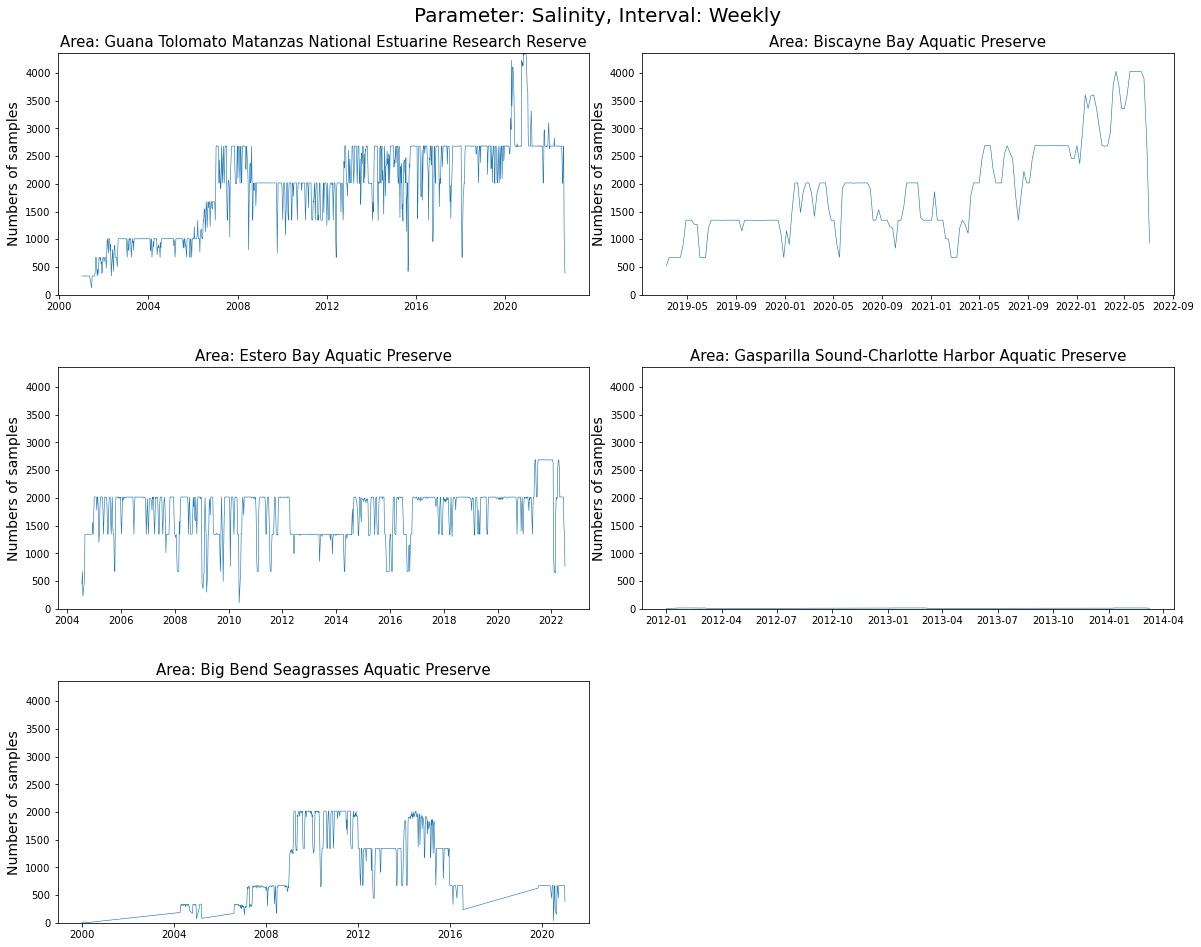

<Figure size 1440x1152 with 0 Axes>

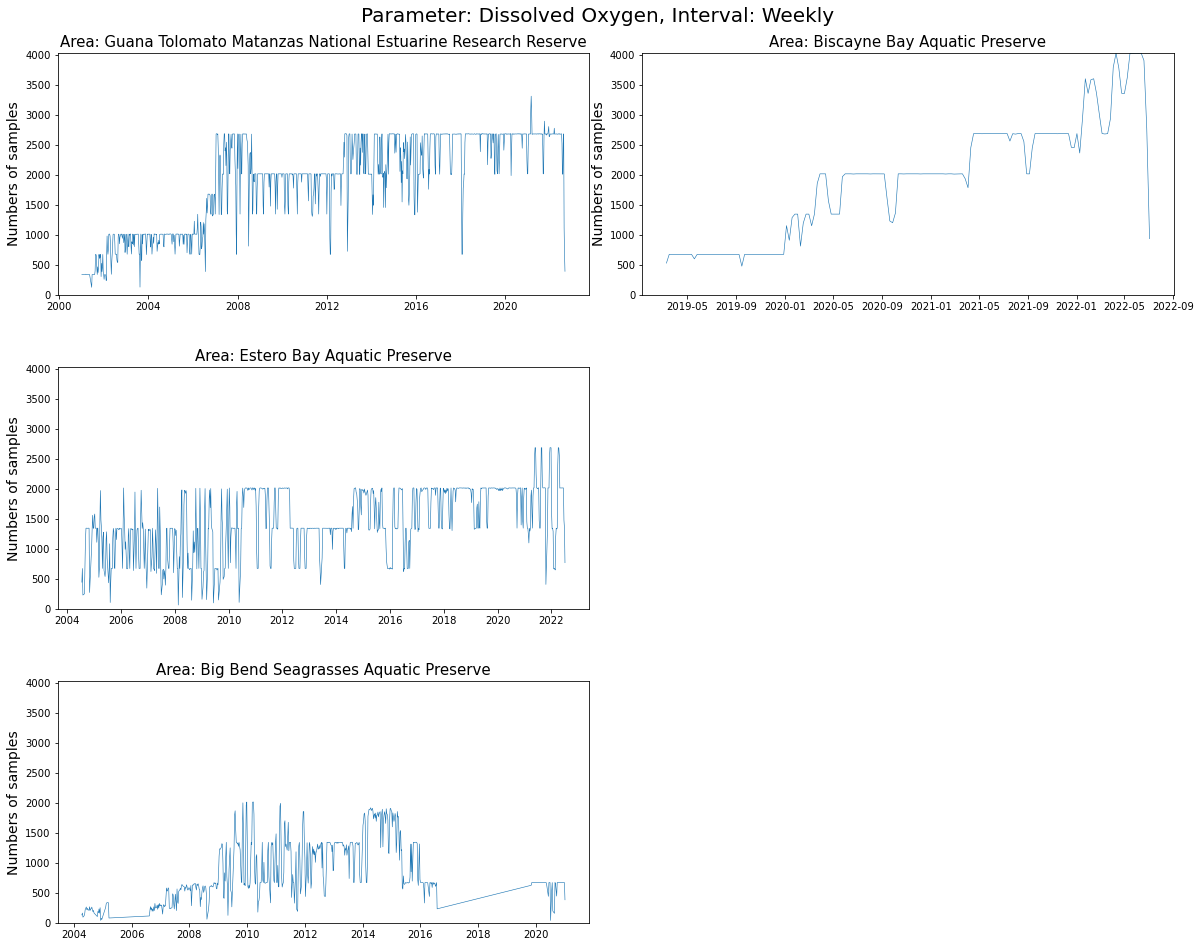

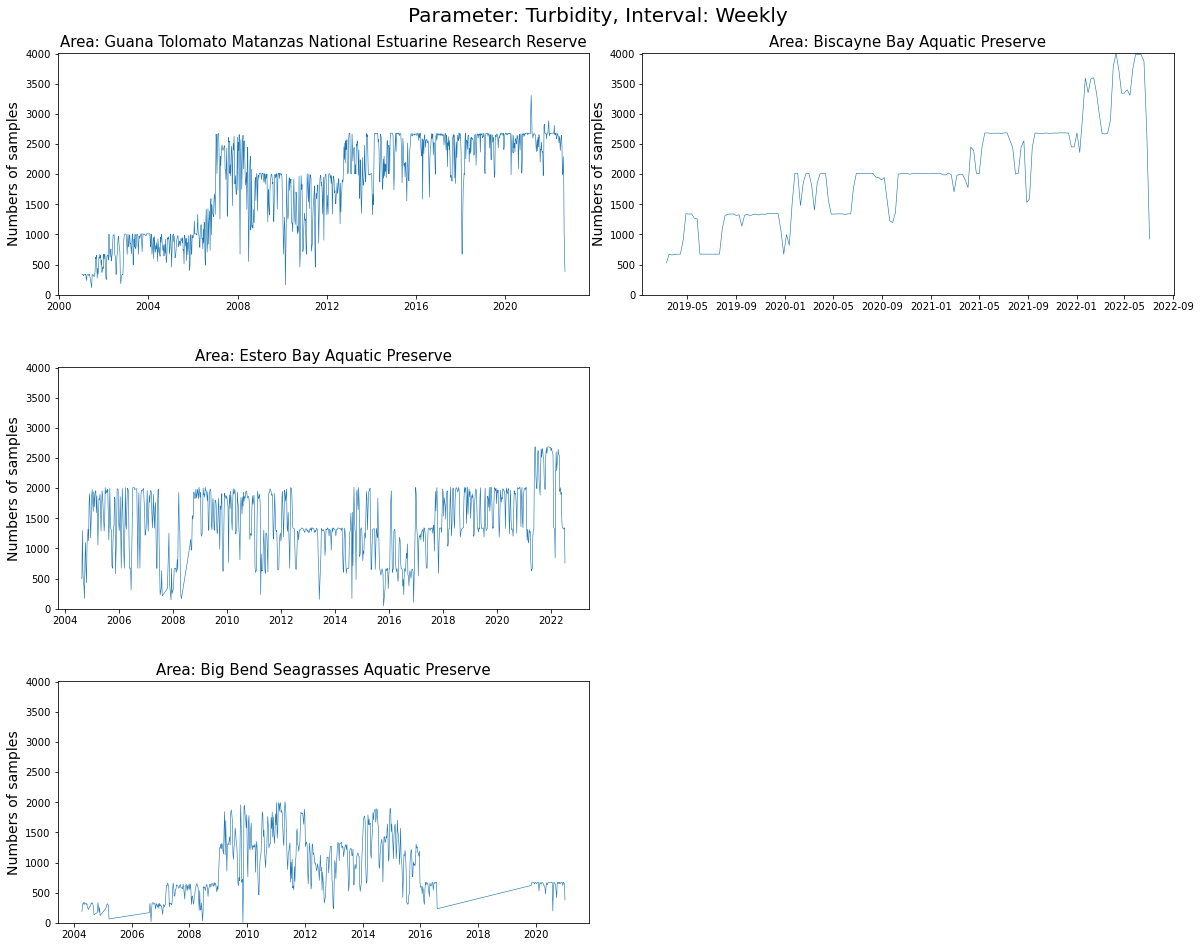

<Figure size 1440x1152 with 0 Axes>

In [7]:
plt.rcParams['figure.figsize'] = [20, 16]
#for value in listValue:
value = listValue[0]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Parameter: " + para + ", Interval: Weekly", fontsize = 20, y = 0.92)
    # Calculate the upper limit of y axis
    up_lim = weekly_count[(weekly_count["ParameterName"] == para)]['count'].max()
    for i in range(len(listArea)):
        dfNew = weekly_count[(weekly_count["ParameterName"] == para)&(weekly_count["ManagedAreaName"]== listArea[i])]
        if dfNew["ParameterName"].count() != 0:
            ax = fig.add_subplot(3,2,i+1)
            ax.set_title(str('Area: '+ listArea[i]),size=15) # title of subplots
            ax.plot(dfNew["timestamp"],dfNew[str(value)],linewidth=0.6)
            ax.set_ylim([0,up_lim])
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)
            plt.ylabel("Numbers of samples", size = 14) # Y Labels

### 2.2 Monthly Count

Create line charts for sample **counts** in monthly intervals. These line charts shows sampling activity in different time periods.

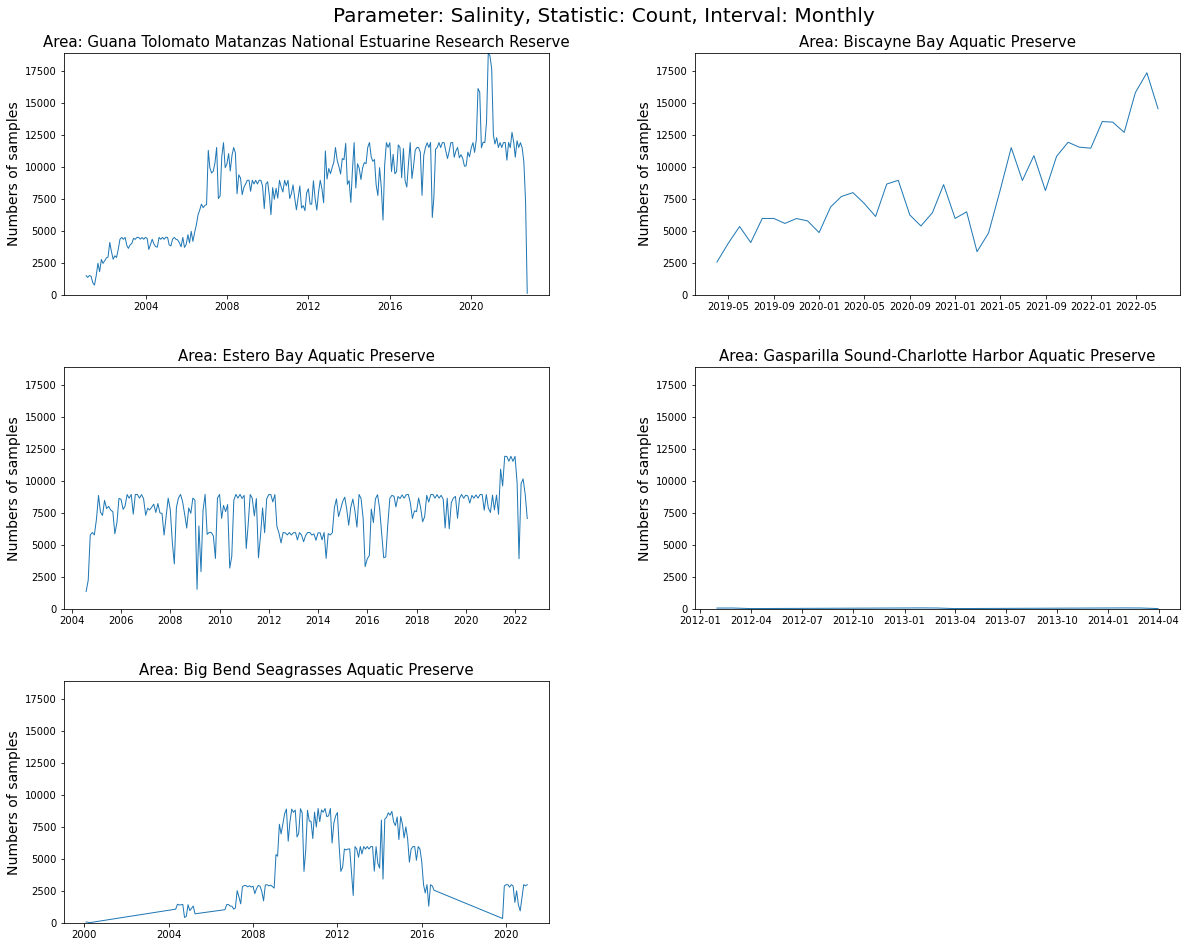

<Figure size 1440x1152 with 0 Axes>

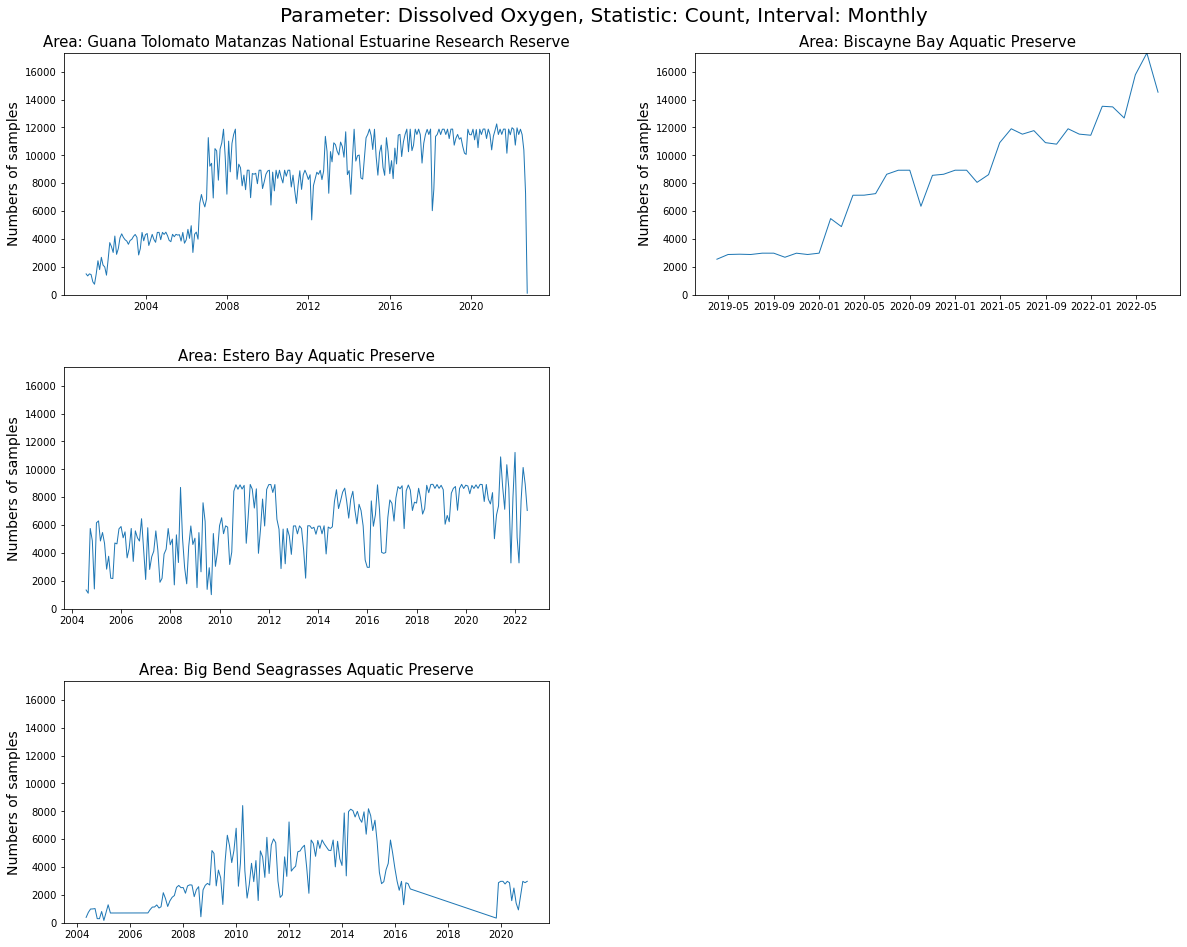

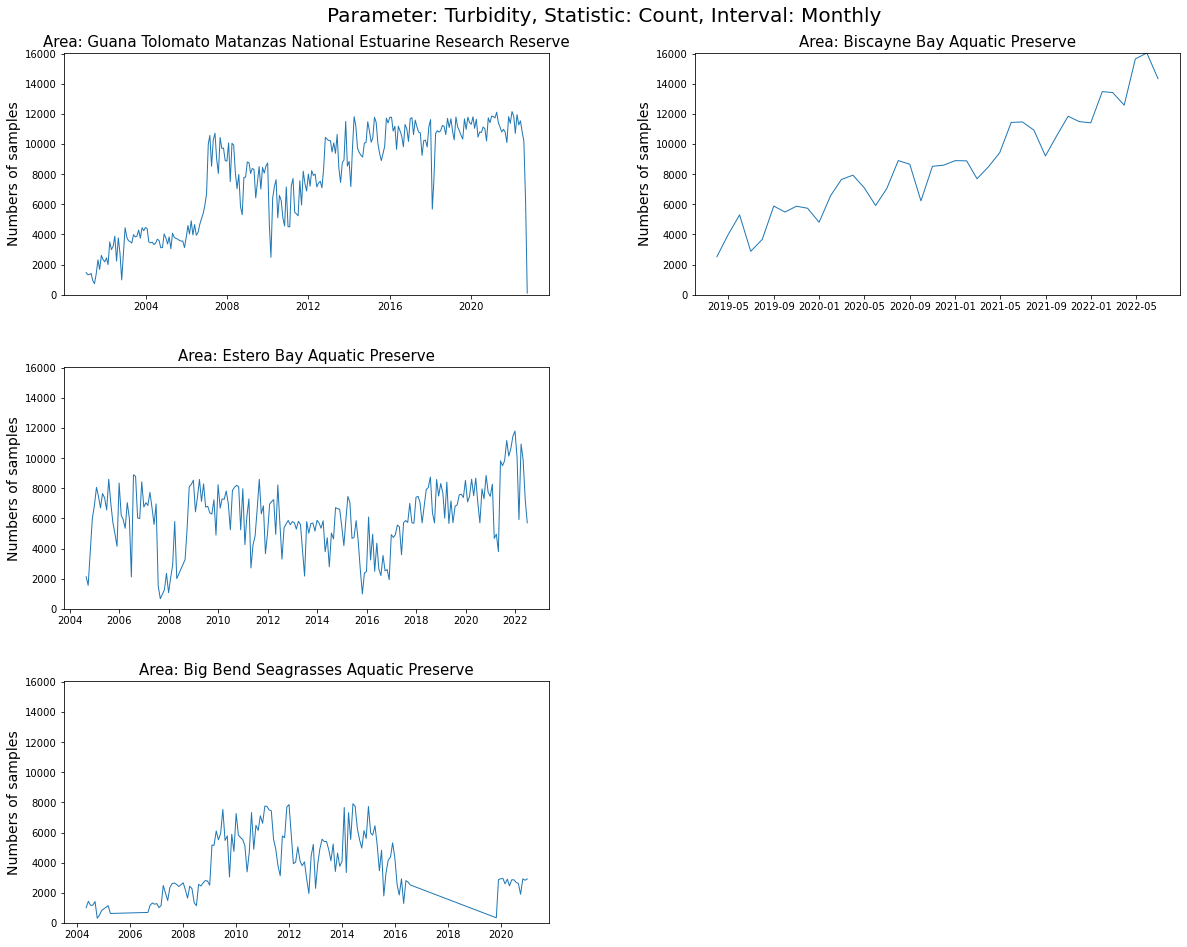

<Figure size 1440x1152 with 0 Axes>

In [8]:
plt.rcParams['figure.figsize'] = [20, 16]
#for value in listValue:
value = listValue[0]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Parameter: " + para + ", Statistic: " + value.capitalize() + ", Interval: Monthly", fontsize = 20, y = 0.92)
    # Calculate the upper limit of y axis
    up_lim = monthly_count[(monthly_count["ParameterName"] == para)]['count'].max()
    for i in range(len(listArea)):
        dfNew = monthly_count[(monthly_count["ParameterName"] == para)&(monthly_count["ManagedAreaName"]== listArea[i])]
        if sum(dfNew[str(value)]) != 0:
            ax = fig.add_subplot(3,2,i+1)
            ax.set_title(str('Area: '+ listArea[i]),size=15) # title of subplots
            ax.plot(dfNew["timestamp"],dfNew[str(value)],linewidth=1)
            ax.set_ylim([0,up_lim])
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
            plt.ylabel("Numbers of samples", size =14)

### 2.3 Monthly Error Bar

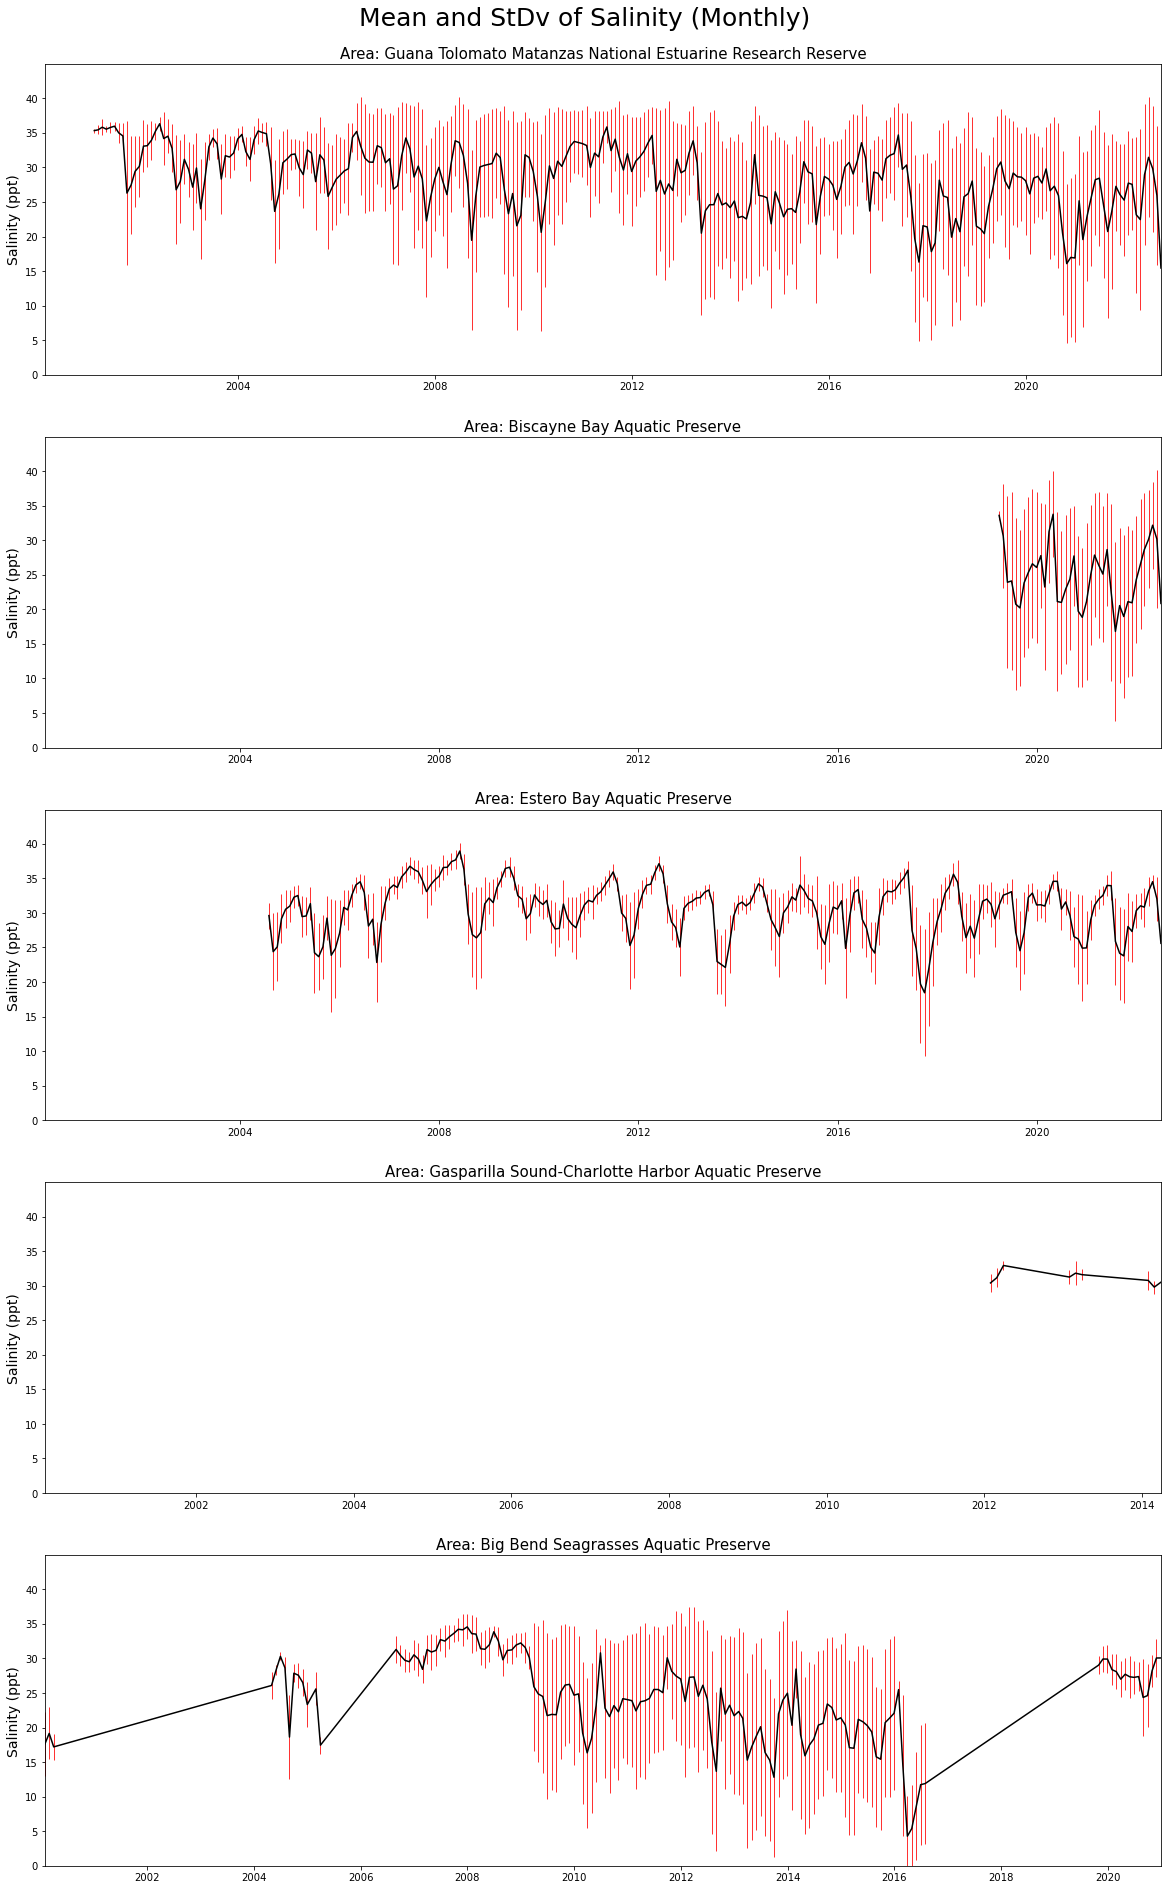

<Figure size 1440x2880 with 0 Axes>

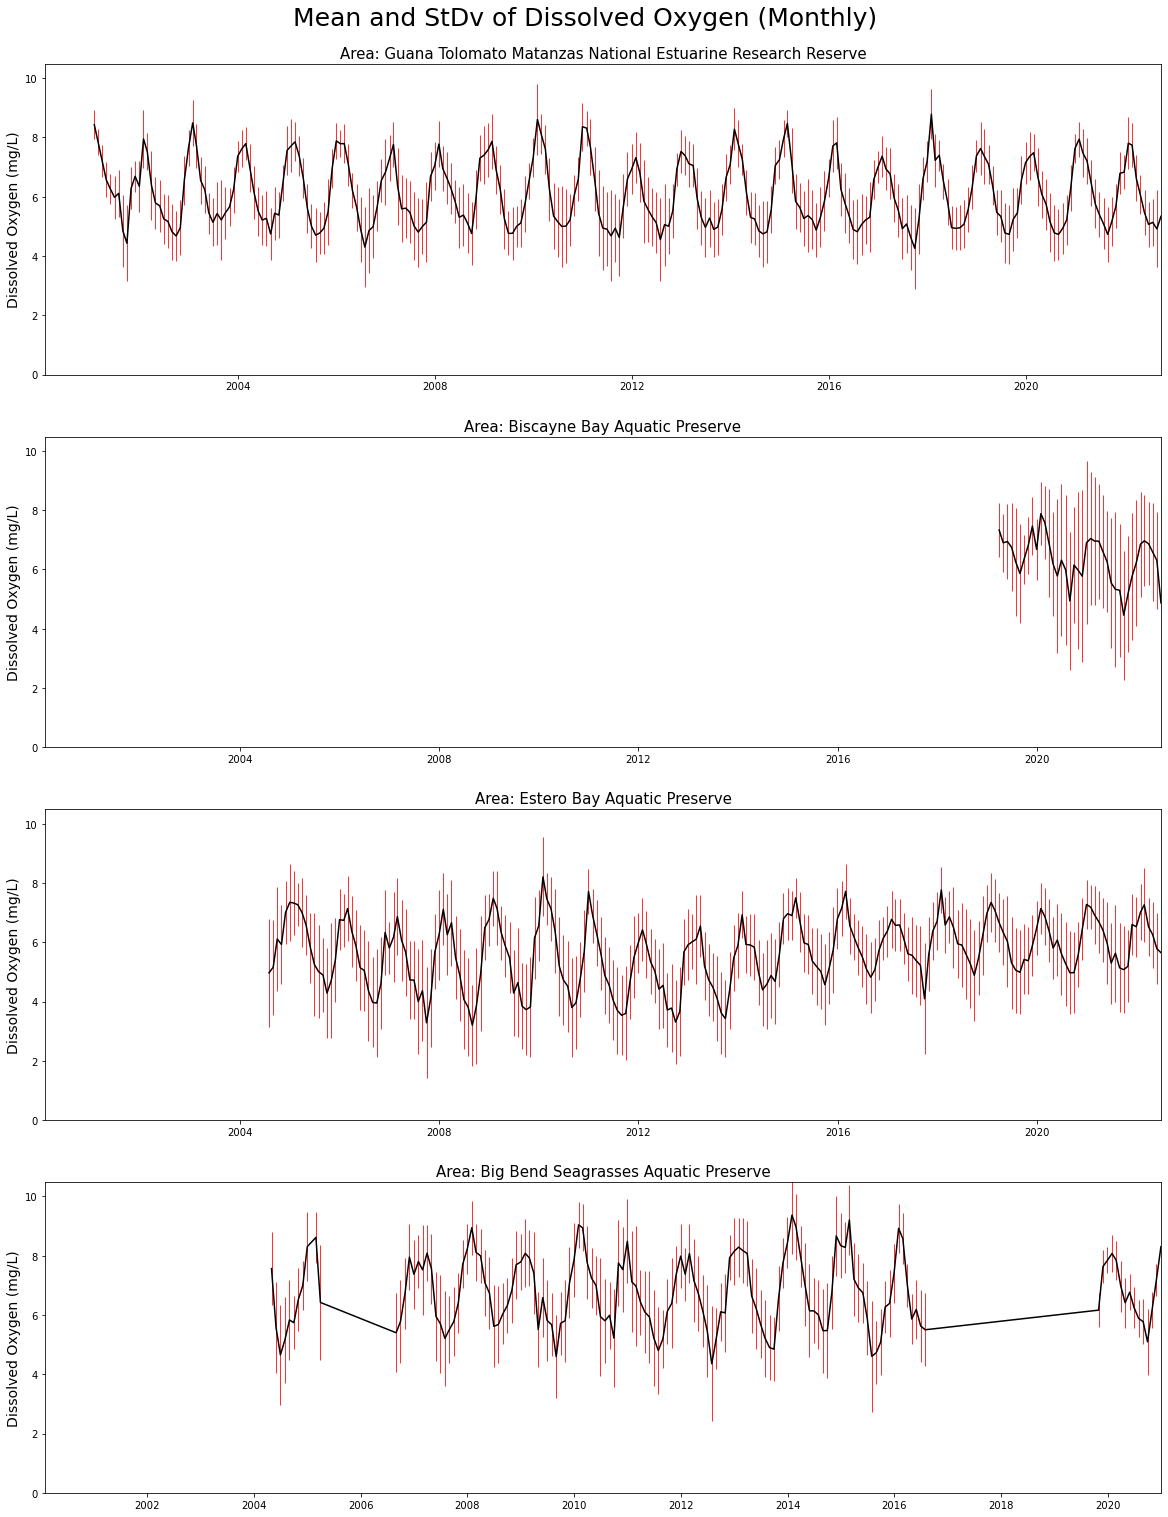

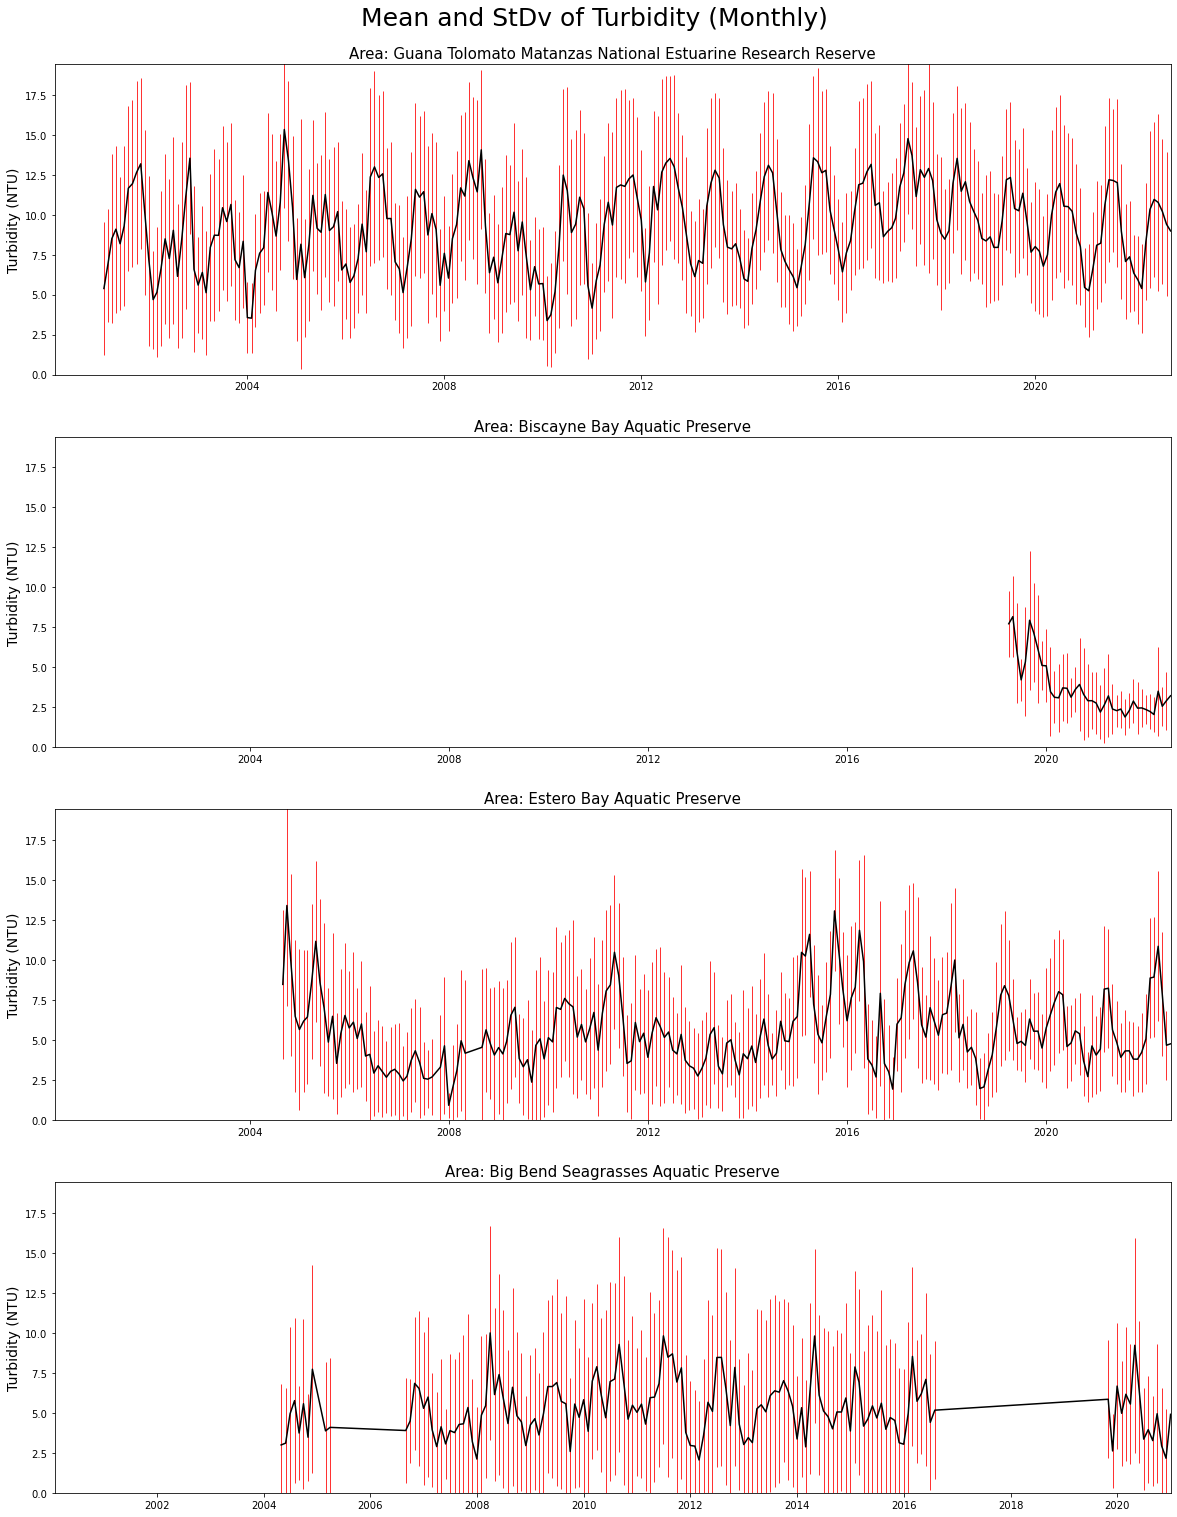

<Figure size 1440x2880 with 0 Axes>

In [12]:
plt.rcParams['figure.figsize'] = [20, 40]
#for value in listValue:
value = listValue[1]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Mean and StDv of {} (Monthly)".format(para), fontsize = 25, y = 0.9)
    # Calculate the upper limit of y axis
    stats = monthly_count[(monthly_count["ParameterName"] == para)]
    up_lim = stats['mean'].max()+stats['std'].mean()
    j = 0
    for i in range(len(listArea)):
        dfNew = monthly_count[(monthly_count["ParameterName"] == para)&(monthly_count["ManagedAreaName"]== listArea[i])]
        if sum(dfNew[str(value)]) != 0:
            ax = fig.add_subplot(6,1,j+1)
            # Set title and font size
            ax.set_title('Area: '+ str(listArea[i]), size=15) # Title
            ax.errorbar(dfNew["timestamp"],dfNew['mean'],dfNew['std'],ecolor='red',elinewidth = 0.8,color="black")
            # Set limit of x and y axis
            ax.set_ylim([0,up_lim])
            ax.set_xlim([pd.Timestamp(monthly_count['timestamp'].min()),dfNew["timestamp"].max()])
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
            plt.ylabel("{} ({})".format(para,dictUnits[para]), size = 14)
            j = j+1

### 2.4 Monthly means (combined)

In [14]:
from datetime import datetime
plt.rcParams['figure.figsize'] = [20, 40]
value = listValue[1]
rule  = rrulewrapper(YEARLY, byeaster=1, interval=1)
loc   = RRuleLocator(rule)
for para in listPara:
    fig = plt.figure()
    plt.suptitle("Mean of {} (Monthly)".format(para), fontsize = 25, y = 0.9)
    j = 0
    for i in range(len(listArea)):
        dfNew= monthly_count[(monthly_count["ParameterName"] == para)&(monthly_count["ManagedAreaName"]== listArea[i])]
        setList = dfNew.ProgramLocationID.unique()
        if len(setList) !=0:
            ax = fig.add_subplot(6,1,j+1)
            ax.set_title('Area: '+ str(listArea[i]), size=15)
            for each in range(len(setList)):
                dfEachValue = dfNew[dfNew["ProgramLocationID"]==setList[each]]
                gap_idx = np.where(np.diff(dfEachValue.timestamp.values.astype(float)/(1000000000*3600*24*365)) > 1)[0]
                dfEachValue = pd.DataFrame(
                    columns = dfEachValue.columns, 
                    data = np.insert(dfEachValue.values, gap_idx+1, values=np.nan, axis=0)
                    )
                ax.plot(dfEachValue["timestamp"],dfEachValue[str(value)],label=setList[each])
                ax.legend(loc='best')
                ax.xaxis.set_major_locator(loc)
                plt.xticks(rotation=90)
                ax.set_xlim([pd.Timestamp('2000-01-01'),dfEachValue["timestamp"].max()])
            j = j+1

NameError: name 'rrulewrapper' is not defined

### 2.4 Yearly Error Bars

Black line is the mean and red lines are -1/+1 standard deviation.

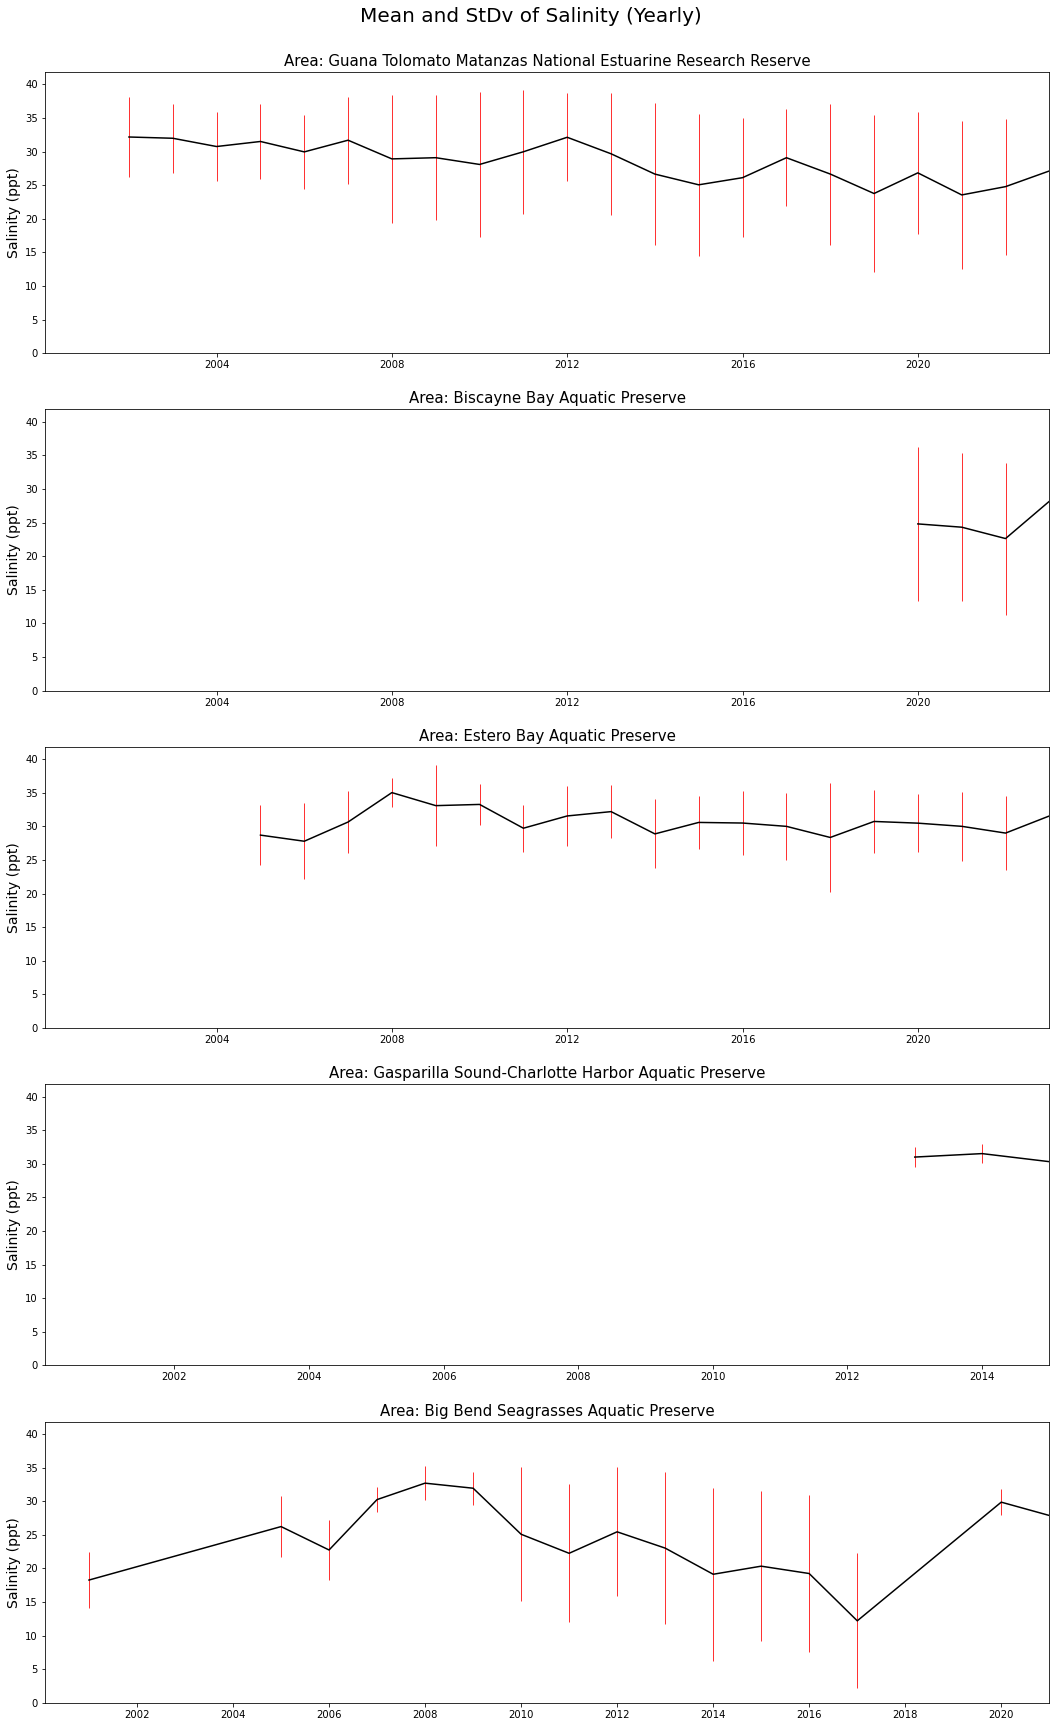

<Figure size 1296x2160 with 0 Axes>

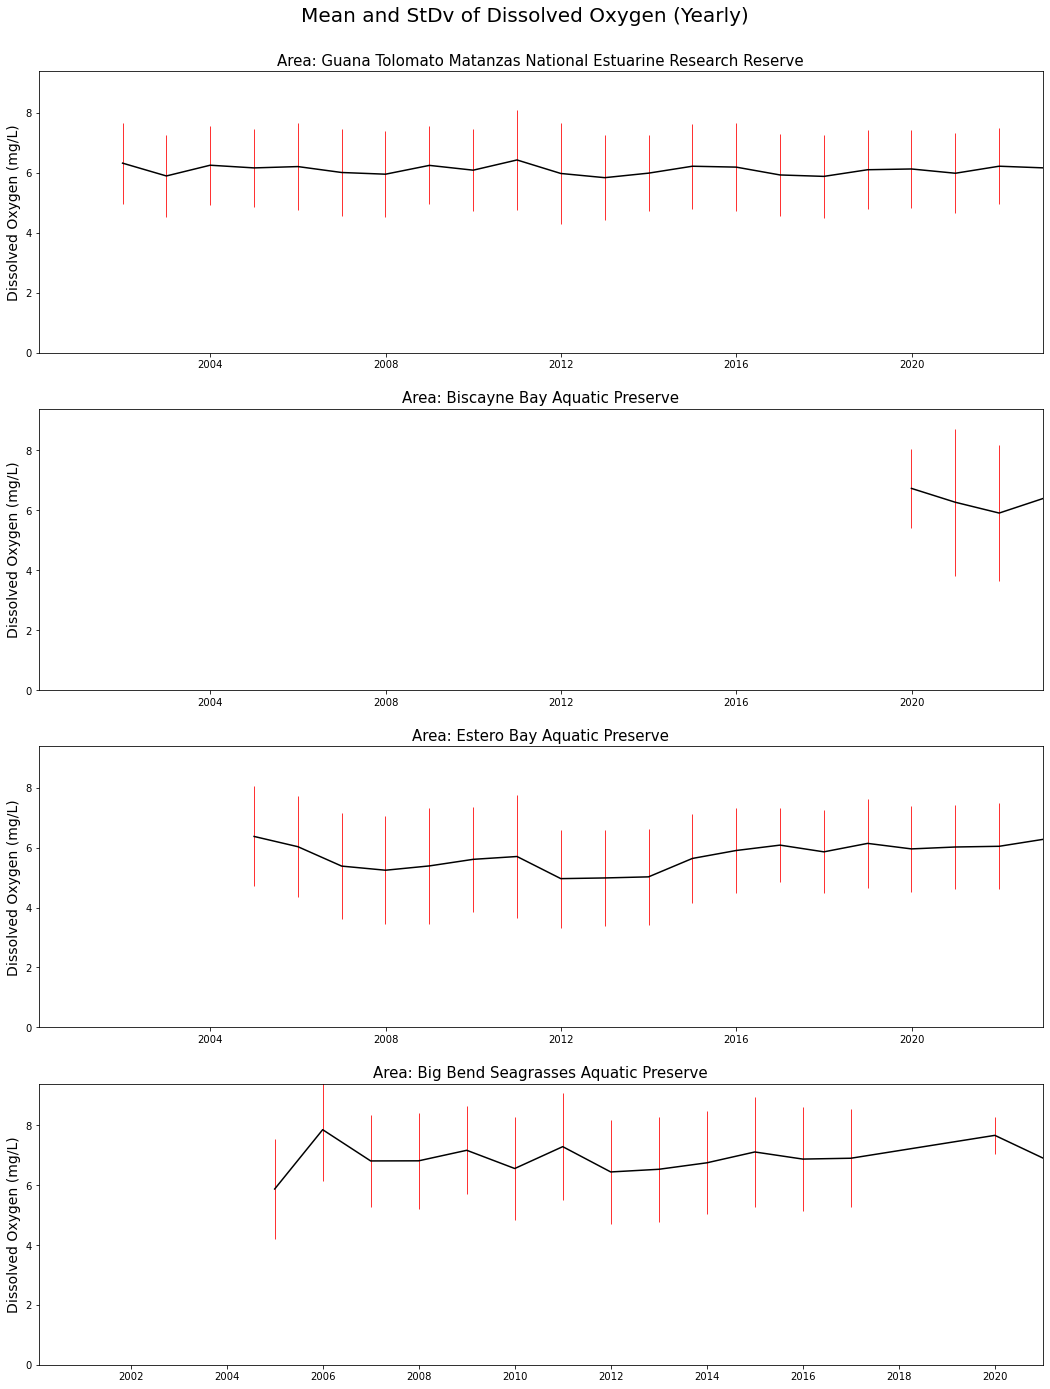

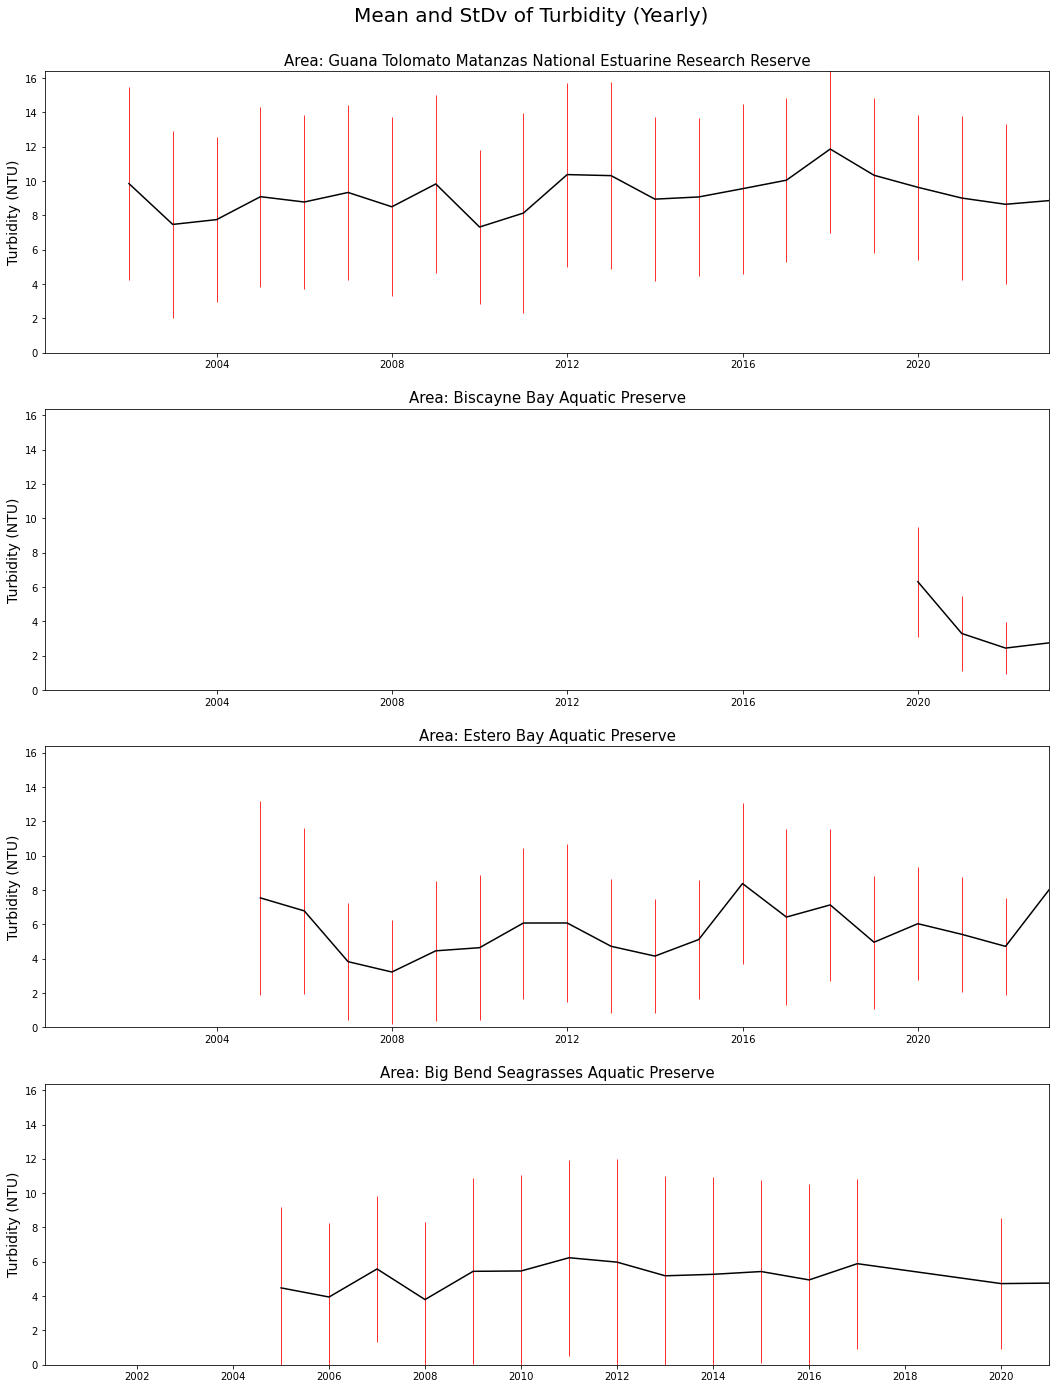

<Figure size 1296x2160 with 0 Axes>

In [13]:
plt.rcParams['figure.figsize'] = [18, 30]
#for value in listValue:
value = listValue[1]
for para in listPara:
    fig = plt.figure()
    # Create the main title
    plt.suptitle("Mean and StDv of {} (Yearly)".format(para), fontsize = 20, y = 0.91)
    # Calculate the upper limit of y axis
    stats = yearly_count[(yearly_count["ParameterName"] == para)]
    up_lim = stats['mean'].max()+stats['std'].mean()
    j = 0
    for i in range(len(listArea)):
        dfNew = yearly_count[(yearly_count["ParameterName"] == para) & (yearly_count["ManagedAreaName"]== listArea[i])]
        if dfNew["ParameterName"].count() != 0:
            ax = fig.add_subplot(5,1,j+1)
            # Set title and font size
            ax.set_title('Area: '+ str(listArea[i]), size=15) # Title
            ax.errorbar(dfNew["timestamp"],dfNew['mean'],dfNew['std'],ecolor='red',elinewidth = 0.8,color="black")
            # Set limit of x and y axis
            ax.set_ylim([0,up_lim])
            ax.set_xlim([pd.Timestamp(monthly_count['timestamp'].min()),dfNew["timestamp"].max()])
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
            plt.ylabel("{} ({})".format(para,dictUnits[para]), size = 14)
            j = j+1

### 2.5 Statistics by Months

The following boxplots are statistics in the same months in different years. 

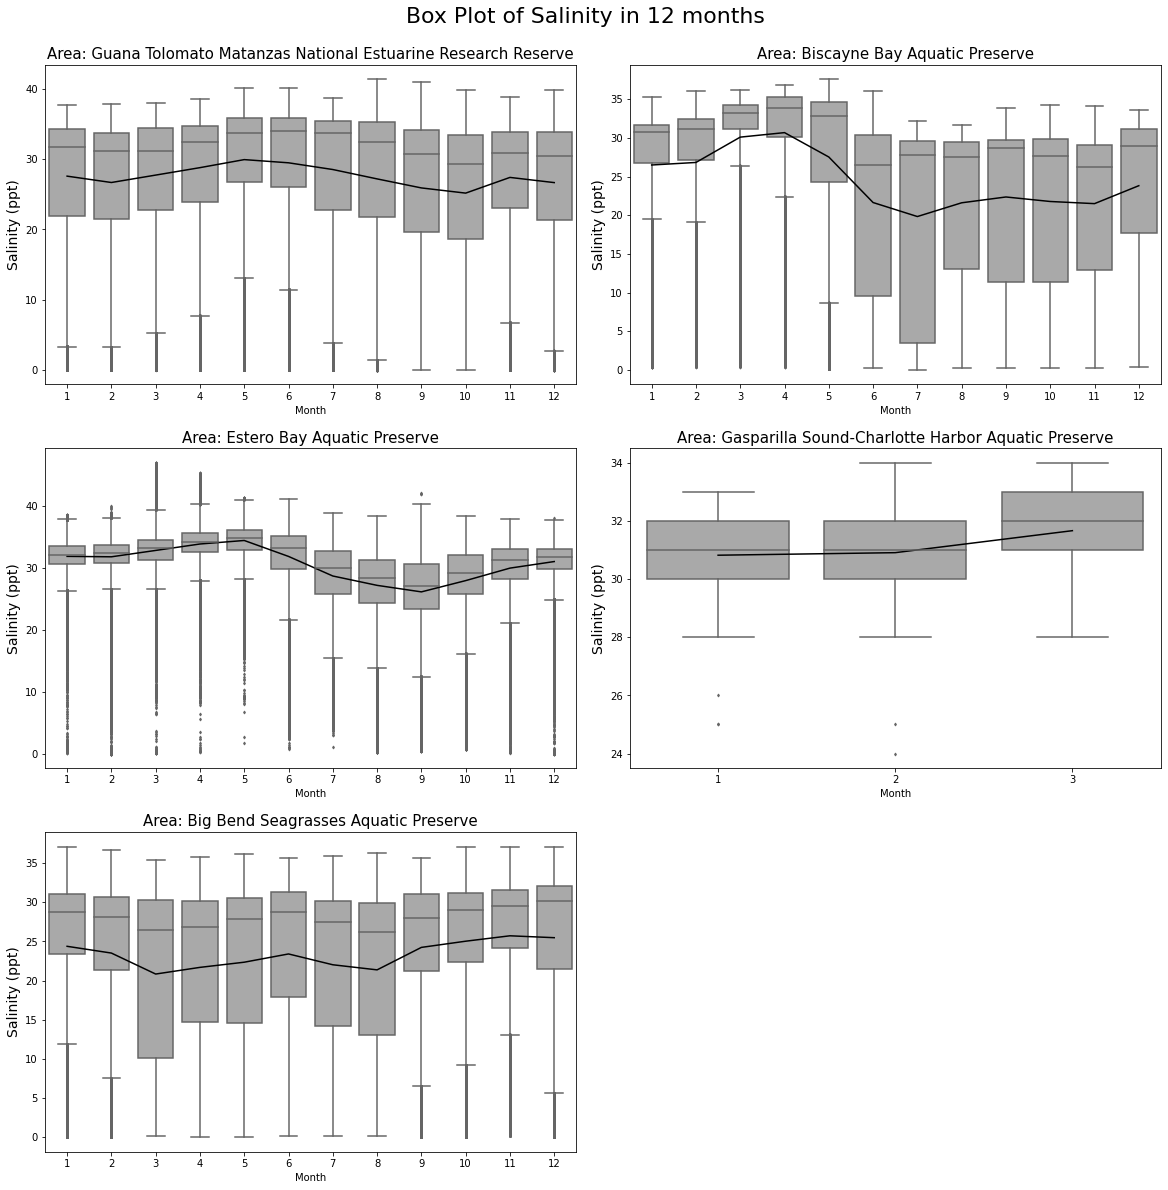

<Figure size 1440x1440 with 0 Axes>

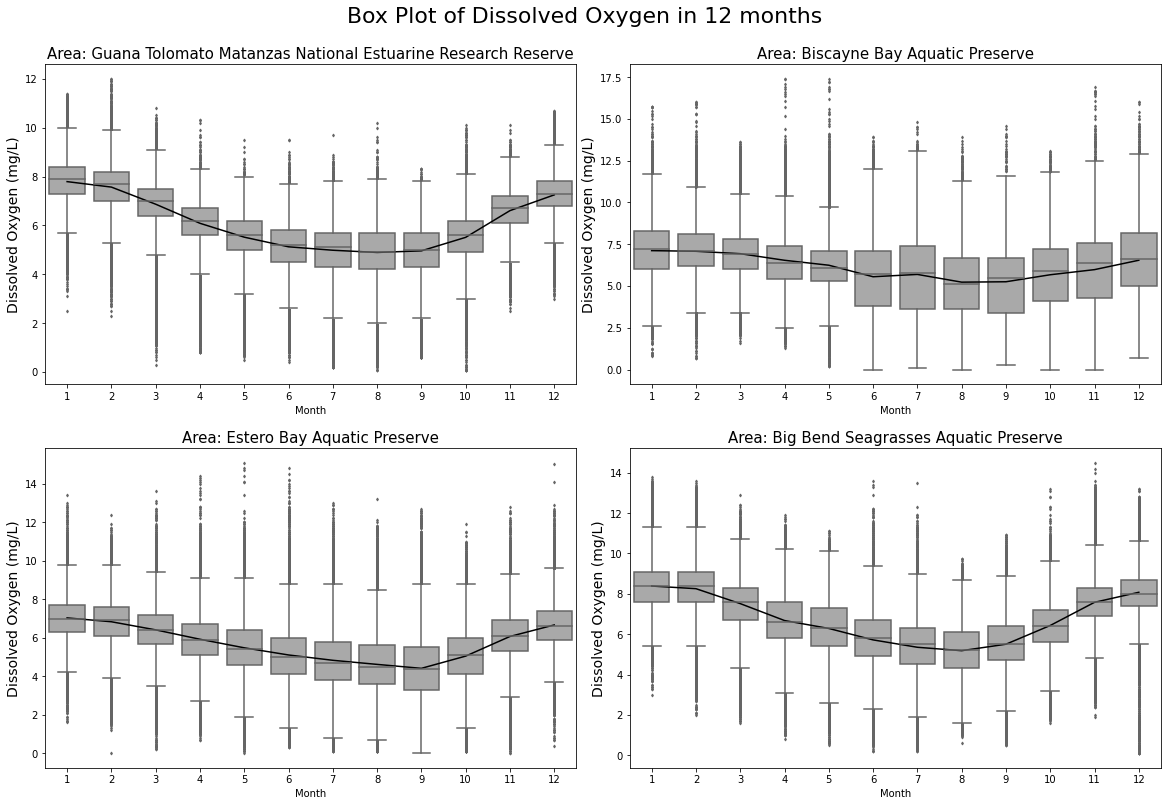

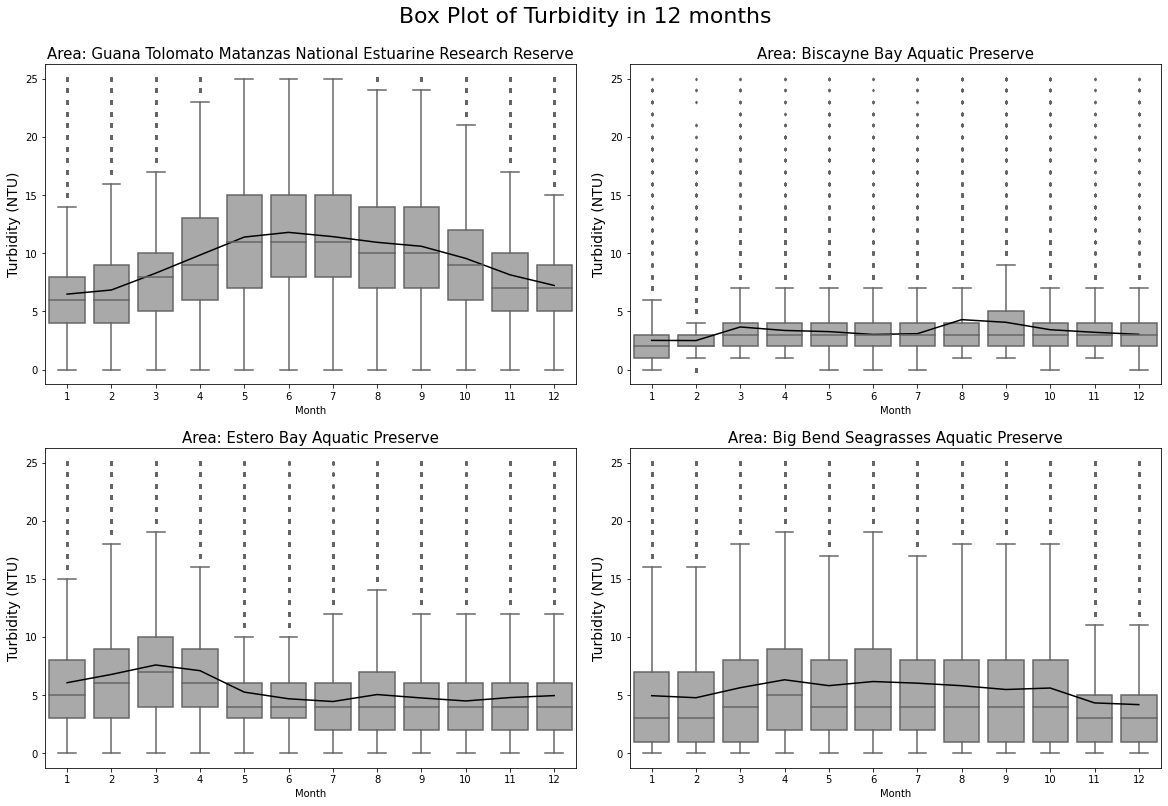

<Figure size 1440x1440 with 0 Axes>

In [18]:
plt.rcParams['figure.figsize'] = [20, 20]
# Group the data by each month
df3 = df2.groupby(["Month","ManagedAreaName","ParameterName"])["ResultValue"].agg([
    "count","max","min","mean","std"]).reset_index()
for para in listPara:
    fig = plt.figure()
    plt.suptitle("Box Plot of {} in 12 months".format(para), fontsize = 22, y = 0.92)
    i=0
    for area in listArea:
        df4 = df2[(df2["ManagedAreaName"]==area)&(df2["ParameterName"]==para)]
        df3_slct = df3[(df3["ManagedAreaName"]==area)&(df3["ParameterName"]==para)]
        if df3_slct["ParameterName"].count() != 0:
#         print(str(df3_slct["ParameterName"].count())+"     "+para)
            ax = fig.add_subplot(3,2,i+1)
            sns.boxplot(x=df4["Month"], y=df4["ResultValue"],orient='v',color='darkgray',fliersize=2, ax = ax)
            sns.lineplot(x=df3_slct["Month"]-1, y=df3_slct["mean"],color='black',ax=ax)
            ax.set_title("Area: {}".format(area), size=15) # Title
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)
            plt.ylabel("{} ({})".format(para,dictUnits[para]), size = 14)        
            i = i + 1